# 🎮 **Steam Review Scraper**

Hecho por [Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR) y [Alvaro López Guerrero](https://github.com/Alvalogue72).

Repositorio: **[GitHub](https://github.com/Alejandro-BR/Steam-Review-Scraper)**

**Máster de FP en Inteligencia Artificial y Big Data**


## **Imagen general**

Extrae datos textuales de los comentarios de Steam y realiza un análisis de sentimientos y emociones, generando estadísticas cuantitativas y visualizaciones gráficas para su interpretación.

## **Importaciones**

In [67]:
import json
import re
import time
from datetime import datetime
from html import unescape

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

## **Obtención de los datos**

Para llevar a cabo el proyecto, hicimos una búsqueda de los datos de las dos formas posibles que ofrece **Steam**, mediante **web scraping** y usando su **API**.

Aunque para trabajar con los datos solo utilizaremos la **API**, ya que el **web scraping** es mucho más costoso y tarda cantidades de tiempo muy elevadas y en cambio, con la **API** podemos obtener más datos en mucho menos tiempo.

### **Call of Duty®: Black Ops 7**

Utilizaremos como ejemplo el juego: [**Call of Duty®: Black Ops 7**](https://store.steampowered.com/app/3606480/Call_of_Duty_Black_Ops_7/)

El cual salió el 14 de noviembre de 2025.

#### **Acerca de este juego:**

Con Call of Duty®: Black Ops 7, Treyarch y Raven Software traen la mayor entrega de Black Ops.

Corre el año 2035 y el mundo está al borde del caos, devastado por violentos conflictos y una guerra psicológica sin precedentes. David Mason lidera un equipo de élite en una misión encubierta en la extensa ciudad de Avalon. Allí descubren un plan sofisticado que no solo sumirá al mundo en el caos, sino que también los arrastrará a enfrentarse con con los fantasmas de su propio pasado.

Forma equipo o juega en solitario en una innovadora campaña cooperativa que redefine la experiencia de Black Ops.

El Multijugador llega pisando fuerte con 16 emocionantes mapas Multijugador 6c6 y dos mapas 20c20 en el lanzamiento. Domina un arsenal de tecnología puntera y supera a tus enemigos con un sistema de movimiento omnidireccional evolucionado.

En el legendario modo de Zombis por rondas de Treyarch, la pesadilla comienza donde termina la realidad. El equipo está atrapado en el corazón del éter oscuro y deberá abrirse paso por un extenso infierno cambiante en el mayor mapa de Zombis por rondas de la historia de Black Ops.

| Requisito         | Mínimo                                           | Recomendado                                    |
|------------------|-------------------------------------------------|-----------------------------------------------|
| Sistema Operativo | Windows® 10 64 Bit (última actualización)      | Windows® 11 64 Bit (última actualización)     |
| Procesador       | AMD Ryzen™ 5 1400 o Intel® Core™ i5-6600       | AMD Ryzen™ 5 1600X o Intel® Core™ i7-6700K   |
| Memoria RAM      | 8 GB                                            | 12 GB                                         |
| Tarjeta Gráfica  | AMD Radeon™ RX 470, NVIDIA® GTX 970/1060 o Intel® Arc™ A580 | AMD Radeon™ RX 6600XT, NVIDIA® RTX 3060 o Intel® Arc™ B580 |
| DirectX          | Versión 12                                      | Versión 12                                    |
| Conexión         | Banda ancha a Internet                          | Banda ancha a Internet                        |
| Almacenamiento   | SSD con 161 GB disponibles                      | SSD con 161 GB disponibles                    |



In [68]:
ID = 3606480  # Call of Duty®: Black Ops 7

### **API de Steam**

Hemos limitado el conjunto de datos a **10.000 reseñas** para evitar tiempos de carga largos al descargar los comentarios.

Documentación: [API OFICIAL](https://partner.steamgames.com/doc/store/getreviews?l=spanish&language=english)

```python
url = f"https://store.steampowered.com/appreviews/{id}"
```





Logs personalizados para mostrar lo que va ocurriendo durante la obtención de los datos.

In [69]:
def log(message, level="INFO"):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] [{level}] {message}")

Elimina cualquier etiqueta `HTML` presente en el texto.

In [70]:
def clean_html(text):
    text = unescape(text)
    text = re.sub(r"<.*?>", "", text)
    return text.strip()

Realiza un `GET` a la API de Steam usando los parámetros necesarios.

In [71]:
def fetch_reviews(id, cursor="*"):
    url = f"https://store.steampowered.com/appreviews/{id}"
    params = {
        "json": 1,
        "language": "spanish",
        "filter": "all",
        "review_type": "all",
        "purchase_type": "all",
        "num_per_page": 100,
        "cursor": cursor
    }
    try:
        r = requests.get(url, params=params, timeout=20)
        return r.json()
    except Exception as e:
        log(f"Error interpretando JSON: {e}", level="ERROR")
        return None

Construye nuestro `DataFrame`.

In [72]:
def scrape_to_dataframe(id, max = 10000):
    cursor = "*"
    total = 0
    data_list = []

    while True:
        log(f"Solicitando cursor: {cursor}")
        data = fetch_reviews(id, cursor)
        if not data or "success" not in data or data["success"] != 1:
            log("Error o respuesta inválida", level="ERROR")
            break

        reviews = data.get("reviews", [])
        if not reviews:
            log("No hay más reseñas. Fin.", level="DONE")
            break

        for r in reviews:
            item = {
                "recommended": r.get("voted_up"),
                "hours": r.get("author", {}).get("playtime_forever", 0) / 60,
                "timestamp_created": r.get("timestamp_created"),
                "timestamp_updated": r.get("timestamp_updated"),
                "review": clean_html(r.get("review", "")),
            }
            data_list.append(item)
            total += 1

            if total >= max:
                log(f"Límite de {max} reseñas alcanzado. Fin.", level="DONE")
                df = pd.DataFrame(data_list)
                return df

        log(f"Descargadas hasta ahora: {total}")
        cursor = data.get("cursor")
        if not cursor:
            log("Cursor vacío -> fin", level="DONE")
            break

        time.sleep(1.2)

    df = pd.DataFrame(data_list)
    log(f"FIN — Total reseñas en DataFrame: {len(df)}", level="DONE")
    return df

Obtenemos el dataframe con 10.000 reseñas.

In [73]:
MAX_REVIEWS = 10000
reviews_df = scrape_to_dataframe(ID, MAX_REVIEWS)

[2025-11-29 12:26:38] [INFO] Solicitando cursor: *
[2025-11-29 12:26:38] [INFO] Descargadas hasta ahora: 37
[2025-11-29 12:26:40] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:40] [INFO] Descargadas hasta ahora: 74
[2025-11-29 12:26:41] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:42] [INFO] Descargadas hasta ahora: 111
[2025-11-29 12:26:43] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:43] [INFO] Descargadas hasta ahora: 148
[2025-11-29 12:26:44] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:45] [INFO] Descargadas hasta ahora: 185
[2025-11-29 12:26:46] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:46] [INFO] Descargadas hasta ahora: 222
[2025-11-29 12:26:47] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:48] [INFO] Descargadas hasta ahora: 259
[2025-11-29 12:26:49] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-11-29 12:26:49] [INFO

Podemos observar que disponemos de si el usuario recomienda o no el juego, las horas que jugó, las fechas y lo que nos interesa la `review`.

In [74]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        10000 non-null  bool   
 1   hours              10000 non-null  float64
 2   timestamp_created  10000 non-null  int64  
 3   timestamp_updated  10000 non-null  int64  
 4   review             10000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 322.4+ KB


In [75]:
reviews_df

,recommended,hours,timestamp_created,timestamp_updated,review
0,False,0.0,1763215663,1763456058,(Actuais todos como si comprara todos los cods...
1,False,0.0,1763263727,1763263727,"TREMENDO BODRIO, CALL OF DUTY BLACK OPS 6, NI ..."
2,False,0.0,1763400014,1763400014,Menudo mojón... Lo he comprado hace 1h y ya me...
3,False,0.0,1763266112,1763266112,"los zombies mi pasión, las mujeres negras mi p..."
4,False,0.0,1763722588,1763722588,Lo volvi a jugar por que habian quitado partid...
...,...,...,...,...,...
9995,False,0.0,1763509238,1763509238,"He de reconocer que lo han logrado, han lograd..."
9996,False,0.0,1763784528,1763784528,Tiene SBMM cuando dijeron que lo habian quitad...
9997,False,0.0,1763115644,1763115644,antes el 6 iba de puta madre pero han metido u...
9998,False,0.0,1763617853,1763617853,juego de mierda en medio de la ronda 31 de zom...


### **Web scraping de Steam**

Hemos limitado el conjunto de datos a **100 reseñas** para evitar tiempos de carga de varias horas al descargar los comentarios.

Este apartado es solo de prueba y no se utilizará en el resto del proyecto, ya que es menos eficiente.

In [76]:
session = requests.Session()

session.cookies.set("birthtime", "0")
session.cookies.set("lastagecheckage", "1-0-1900")
session.cookies.set("wants_mature_content", "1")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "es-ES,es;q=0.9"
}

reviews_list = []
page = 1
MAX_REVIEWS_SCRAPING = 100

while True:
    print(f"[INFO] Scrapeando página {page}...")

    url = (
        f"https://steamcommunity.com/app/{ID}/reviews/"
        f"?p={page}&browsefilter=toprated&filterLanguage=spanish&l=spanish"
    )

    response = session.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    reviews_html = soup.find_all("div", class_="apphub_CardTextContent")

    if not reviews_html:
        print("[DONE] No hay más comentarios en esta página. Fin.")
        break

    for r in reviews_html:
        text = r.get_text(strip=True)
        if text:
            reviews_list.append(text)
            if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
                print(f"[DONE] Límite de {MAX_REVIEWS_SCRAPING} comentarios alcanzado. Fin.")
                break

    if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
        break

    page += 1
    time.sleep(1)

scraping_df = pd.DataFrame(reviews_list, columns=["review"])
print(f"\n[INFO] Total comentarios extraídos: {len(scraping_df)}")


[INFO] Scrapeando página 1...
[INFO] Scrapeando página 2...
[INFO] Scrapeando página 3...
[INFO] Scrapeando página 4...
[INFO] Scrapeando página 5...
[INFO] Scrapeando página 6...
[DONE] No hay más comentarios en esta página. Fin.

[INFO] Total comentarios extraídos: 55


Ya tenemos los datos guardados en el dataframe, pero podemos observar que no vienen completamente limpios.

In [77]:
scraping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  55 non-null     object
dtypes: object(1)
memory usage: 572.0+ bytes


In [78]:
scraping_df

,review
0,Vote for Call of Duty: Black Ops 7 as your fav...
1,Do you think they'll fix the issues in the new...
2,Welcome to the neighborhood 🏘️ Step into the B...
3,Call of Duty: Black Ops 7 is available now and...
4,Publicada el 27 de noviembreRefund because it’...
5,Publicada el 24 de noviembrenice
6,Publicada el 23 de noviembreahora que pesa men...
7,"This or BF6, what do u suggest, boys?"
8,How i can fix my LOCKED FPS ???\n\nMy pc not p...
9,Has anyone experience being shadow banned as i...


Limpiamos los comentarios eliminando la fecha de publicación inicial.

In [93]:
def clean_sc_text(x):
    # Patrón flexible
    x = re.sub(r"^Publicada\s*el\s*\d{1,2}\s*de\s*[\wáéíóúñ]+\s*(de\s*\d{4})?", "", x)
    return x.strip()

scraping_df["review"] = scraping_df["review"].apply(clean_sc_text)

In [94]:
print(scraping_df.head())

                                              review
0  Vote for Call of Duty: Black Ops 7 as your fav...
1  Do you think they'll fix the issues in the new...
2  Welcome to the neighborhood 🏘️ Step into the B...
3  Call of Duty: Black Ops 7 is available now and...
4  because it’s unfair that PC players can’t disa...


Aquí ya disponemos de los datos para utilizarlos, aunque como mencioné anteriormente, estos son solo de prueba y utilizaremos los otros.

In [95]:
scraping_df

,review
0,Vote for Call of Duty: Black Ops 7 as your fav...
1,Do you think they'll fix the issues in the new...
2,Welcome to the neighborhood 🏘️ Step into the B...
3,Call of Duty: Black Ops 7 is available now and...
4,because it’s unfair that PC players can’t disa...
5,
6,que pesa menos esta gooood
7,"This or BF6, what do u suggest, boys?"
8,How i can fix my LOCKED FPS ???\n\nMy pc not p...
9,Has anyone experience being shadow banned as i...


## **Exploración y visualización de los datos**

Se realizará un estudio del dataset, mostrando gráficas de diferente tipo, observando valores nulos y realizando otros análisis.

In [82]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        10000 non-null  bool   
 1   hours              10000 non-null  float64
 2   timestamp_created  10000 non-null  int64  
 3   timestamp_updated  10000 non-null  int64  
 4   review             10000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 322.4+ KB


In [83]:
reviews_df.head()

,recommended,hours,timestamp_created,timestamp_updated,review
0,False,0.0,1763215663,1763456058,(Actuais todos como si comprara todos los cods...
1,False,0.0,1763263727,1763263727,"TREMENDO BODRIO, CALL OF DUTY BLACK OPS 6, NI ..."
2,False,0.0,1763400014,1763400014,Menudo mojón... Lo he comprado hace 1h y ya me...
3,False,0.0,1763266112,1763266112,"los zombies mi pasión, las mujeres negras mi p..."
4,False,0.0,1763722588,1763722588,Lo volvi a jugar por que habian quitado partid...


No deberían tener valores nulos ya que están obtenidos oficialmente, pero se comprobará por si acaso.

In [84]:
reviews_df.isnull().sum()

,0
recommended,0
hours,0
timestamp_created,0
timestamp_updated,0
review,0


Podemos observar claramente que está totalmente completo.

Pero comprobaremos que no haya valores inútiles, como cadenas vacías y números 0.

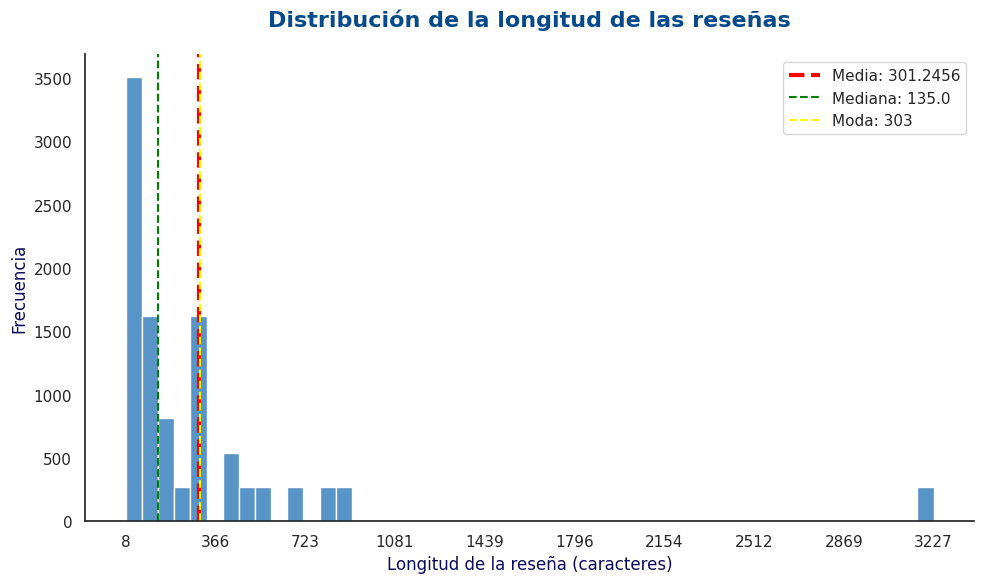

In [85]:
reviews_length = reviews_df["review"].astype(str).str.len()

mean_length = reviews_length.mean()
median_length = reviews_length.median()
mode_length = reviews_length.mode()[0]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=3)

plt.figure(figsize=(10, 6))

sns.histplot(
    x=reviews_length,
    bins=50,
    color=colors[2],
    edgecolor="white"
)

plt.axvline(mean_length, color="red", linestyle="--", linewidth=3, label=f"Media: {mean_length}")
plt.axvline(median_length, color="green", linestyle="--", linewidth=1.5, label=f"Mediana: {median_length}")
plt.axvline(mode_length, color="yellow", linestyle="--", linewidth=1.5, label=f"Moda: {mode_length}")

plt.title(
    "Distribución de la longitud de las reseñas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

plt.xlabel("Longitud de la reseña (caracteres)", fontsize=12, color="#0A0A5A")
plt.ylabel("Frecuencia", fontsize=12, color="#0A0A5A")

plt.xticks(
    ticks=np.linspace(reviews_length.min(), reviews_length.max(), 10)
)

plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


Vemos que **no hay reseñas vacías** y que el mínimo de caracteres es 8 y el máximo es 3.227.

Ahora veremos en el caso de las horas jugadas al juego, que aunque vayamos a borrar este dato porque no nos interesa, es interesante de analizar.

/tmp/ipython-input-2860820429.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


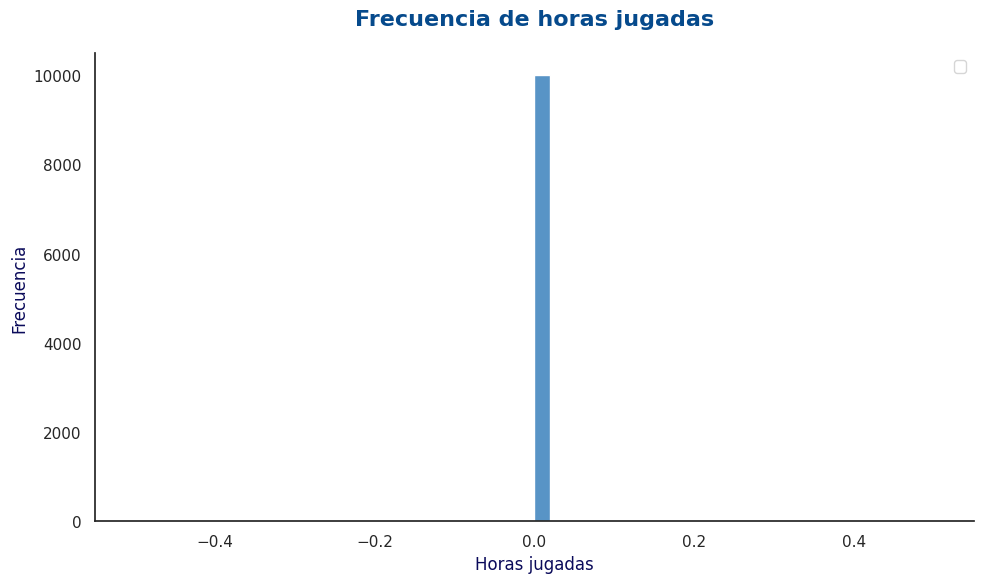

In [86]:
sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=3)

plt.figure(figsize=(10, 6))

sns.histplot(
    data=reviews_df,
    x="hours",
    bins=50,
    color=colors[2],
    edgecolor="white"
)

plt.title(
    "Frecuencia de horas jugadas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

plt.xlabel("Horas jugadas", fontsize=12, color="#0A0A5A")
plt.ylabel("Frecuencia", fontsize=12, color="#0A0A5A")

plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


Vemos que esto se trata de un fallo en la API o en la obtención de los datos, porque siempre nos trajo **0,0 horas jugadas**, lo cual está obviamente mal. De todas formas, este dato no nos interesa para nada y lo vamos a borrar.

Vamos a ver si el usuario recomienda o no el juego. Este dato es importante porque podremos comparar a futuro el porcentaje de positivo y negativo respecto a si el usuario recomienda o no el juego, valores que deberían a priori ser similares.




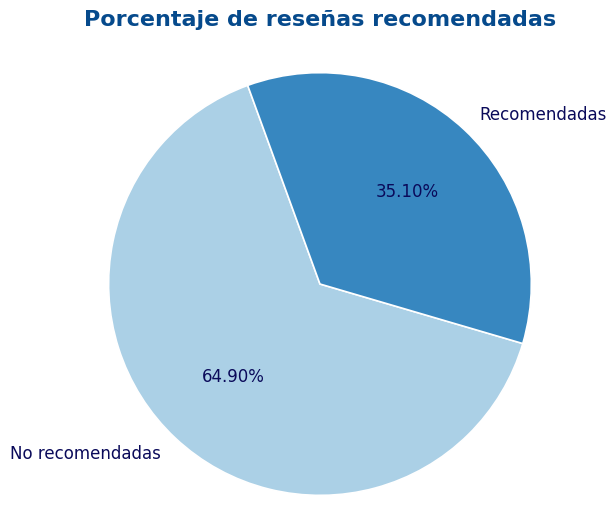

In [87]:
recommended_count = reviews_df['recommended'].sum()
not_recommended_count = len(reviews_df) - recommended_count

labels = ["No recomendadas", "Recomendadas"]
sizes = [not_recommended_count, recommended_count]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    sizes,
    labels=labels,
    autopct="%1.2f%%",
    startangle=110,
    colors=colors,
    textprops={"color": "#0A0A5A", "fontsize": 12},
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"}
)

ax.set_title(
    "Porcentaje de reseñas recomendadas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

ax.axis("equal")

plt.show()


Vemos que de **10.000 usuarios**, solo el **35,10%** recomienda *Call of Duty®: Black Ops 7*, un porcentaje muy bajo de personas a las que les ha gustado este juego que salió recientemente.

## **Preparación de los datos**

En este apartado, vamos a limpiar el dataset para dejarlo listo para analizar los comentarios.

Dejaremos solo las dos columnas que nos interesan la `review` y el `recommended`.

In [88]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        10000 non-null  bool   
 1   hours              10000 non-null  float64
 2   timestamp_created  10000 non-null  int64  
 3   timestamp_updated  10000 non-null  int64  
 4   review             10000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 322.4+ KB


In [89]:
drop_colums = ["hours", "timestamp_created", "timestamp_updated"]
reviews_df.drop(columns=drop_colums, inplace=True)

In [90]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   recommended  10000 non-null  bool  
 1   review       10000 non-null  object
dtypes: bool(1), object(1)
memory usage: 88.0+ KB


El dataset ya podría usarse cómodamente para el análisis de sentimientos y para hacer gráficas respecto a la relación entre el recomendado y los sentimientos del texto.